In [15]:
library(DropletUtils)
library(scater)

sce.pbmc <- read10xCounts("/home/mowp/data/scRNA/pbmc4k/raw_gene_bc_matrices/GRCh38", col.names=TRUE)

In [16]:
rownames(sce.pbmc) <- uniquifyFeatureNames(
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

library(EnsDb.Hsapiens.v86)
location <- mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce.pbmc)$ID, 
    column="SEQNAME", keytype="GENEID")

Warning message:
"Unable to map 144 of 33694 requested IDs."


In [17]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 737280 
metadata(1): Samples
assays(1): counts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(737280): AAACCTGAGAAACCAT-1 AAACCTGAGAAACCGC-1 ...
  TTTGTCATCTTTAGTC-1 TTTGTCATCTTTCCTC-1
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [18]:
set.seed(100)
e.out <- emptyDrops(counts(sce.pbmc))
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]

In [20]:
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce.pbmc <- sce.pbmc[,!high.mito]

In [27]:
library(scran)
set.seed(1000)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster=clusters)
sce.pbmc <- logNormCounts(sce.pbmc)

In [28]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 3985 
metadata(1): Samples
assays(2): counts logcounts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(3985): AAACCTGAGAAGGCCT-1 AAACCTGAGACAGACC-1 ...
  TTTGTCAGTTAAGACA-1 TTTGTCATCCCAAGAT-1
colData names(3): Sample Barcode sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [ ]:
library(scRNAseq)
sce.416b <- LunSpikeInData(which="416b")

In [5]:
sce.416b

class: SingleCellExperiment 
dim: 46604 192 
metadata(0):
assays(1): counts
rownames(46604): ENSMUSG00000102693 ENSMUSG00000064842 ...
  ENSMUSG00000095742 CBFB-MYH11-mcherry
rowData names(1): Length
colnames(192): SLX-9555.N701_S502.C89V9ANXX.s_1.r_1
  SLX-9555.N701_S503.C89V9ANXX.s_1.r_1 ...
  SLX-11312.N712_S508.H5H5YBBXX.s_8.r_1
  SLX-11312.N712_S517.H5H5YBBXX.s_8.r_1
colData names(9): Source Name cell line ... spike-in addition block
reducedDimNames(0):
mainExpName: endogenous
altExpNames(2): ERCC SIRV

In [23]:
library(AnnotationHub)
ens.mm.v97 <- AnnotationHub()[["AH73905"]]
rowData(sce.416b)$ENSEMBL <- rownames(sce.416b)
rowData(sce.416b)$SYMBOL <- mapIds(ens.mm.v97, keys=rownames(sce.416b),
    keytype="GENEID", column="SYMBOL")
rowData(sce.416b)$SEQNAME <- mapIds(ens.mm.v97, keys=rownames(sce.416b),
    keytype="GENEID", column="SEQNAME")

library(scater)
rownames(sce.416b) <- uniquifyFeatureNames(rowData(sce.416b)$ENSEMBL, 
    rowData(sce.416b)$SYMBOL)

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: 'AnnotationHub'


The following object is masked from 'package:Biobase':

    cache


snapshotDate(): 2022-10-31

loading from cache

Warning message:
"Unable to map 563 of 46604 requested IDs."
Warning message:
"Unable to map 563 of 46604 requested IDs."


In [24]:
mito <- which(rowData(sce.416b)$SEQNAME=="MT")
stats <- perCellQCMetrics(sce.416b, subsets=list(Mt=mito))
qc <- quickPerCellQC(stats, percent_subsets=c("subsets_Mt_percent",
    "altexps_ERCC_percent"), batch=sce.416b$block)
sce.416b <- sce.416b[,!qc$discard]

In [25]:
sce.416b

class: SingleCellExperiment 
dim: 46604 185 
metadata(0):
assays(1): counts
rownames(46604): 4933401J01Rik Gm26206 ... CAAA01147332.1
  CBFB-MYH11-mcherry
rowData names(4): Length ENSEMBL SYMBOL SEQNAME
colnames(185): SLX-9555.N701_S502.C89V9ANXX.s_1.r_1
  SLX-9555.N701_S503.C89V9ANXX.s_1.r_1 ...
  SLX-11312.N712_S507.H5H5YBBXX.s_8.r_1
  SLX-11312.N712_S517.H5H5YBBXX.s_8.r_1
colData names(9): Source Name cell line ... spike-in addition block
reducedDimNames(0):
mainExpName: endogenous
altExpNames(2): ERCC SIRV

# Quantifying per-gene variation

The simplest approach to quantifying per-gene variation is to compute the variance of the log-normalized expression values (i.e., “log-counts” ) for each gene across all cells (A. T. L. Lun, McCarthy, and Marioni 2016). The advantage of this approach is that the feature selection is based on the same log-values that are used for later downstream steps. In particular, genes with the largest variances in log-values will contribute most to the Euclidean distances between cells during procedures like clustering and dimensionality reduction. By using log-values here, we ensure that our quantitative definition of heterogeneity is consistent throughout the entire analysis.

Calculation of the per-gene variance is simple but feature selection requires modelling of the mean-variance relationship. The log-transformation is not a variance stabilizing transformation in most cases, which means that the total variance of a gene is driven more by its abundance than its underlying biological heterogeneity. To account for this effect, we use the modelGeneVar() function to fit a trend to the variance with respect to abundance across all genes 

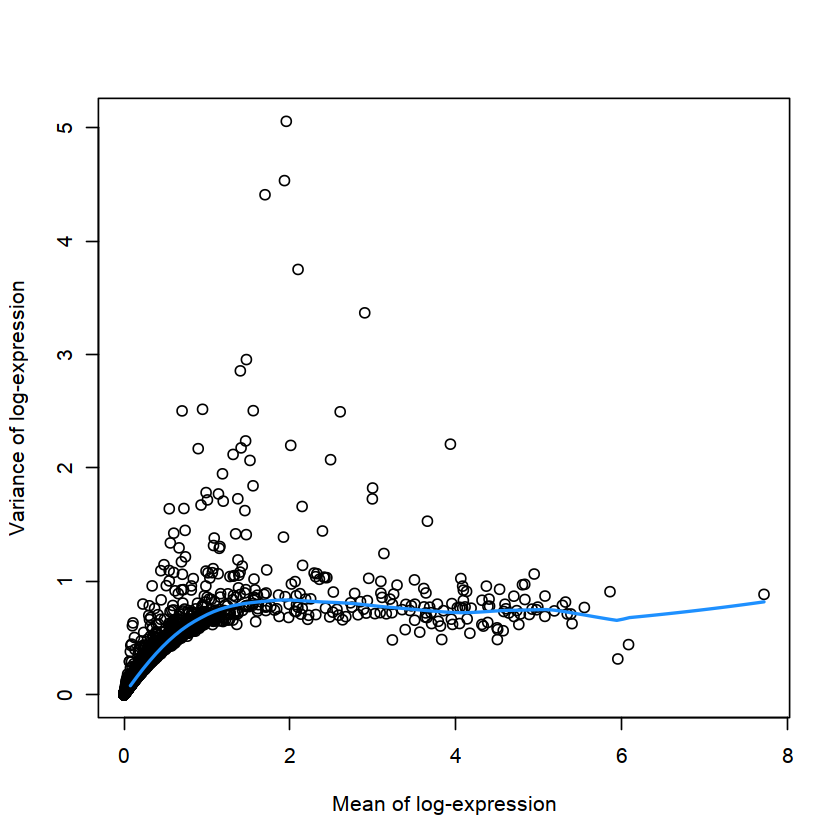

In [29]:
library(scran)
dec.pbmc <- modelGeneVar(sce.pbmc)

# Visualizing the fit:
fit.pbmc <- metadata(dec.pbmc)
plot(fit.pbmc$mean, fit.pbmc$var, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(fit.pbmc$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In [31]:
# Ordering by most interesting genes for inspection.
dec.pbmc[order(dec.pbmc$bio, decreasing=TRUE),] 

DataFrame with 33694 rows and 6 columns
             mean     total      tech       bio      p.value          FDR
        <numeric> <numeric> <numeric> <numeric>    <numeric>    <numeric>
LYZ       1.95605   5.05854  0.835343   4.22320 1.10538e-270 2.17417e-266
S100A9    1.93416   4.53551  0.835439   3.70007 2.71044e-208 7.61594e-205
S100A8    1.69961   4.41084  0.824342   3.58650 4.31582e-201 9.43199e-198
HLA-DRA   2.09785   3.75174  0.831239   2.92050 5.93951e-132 4.86767e-129
CD74      2.90176   3.36879  0.793188   2.57560 4.83937e-113 2.50489e-110
...           ...       ...       ...       ...          ...          ...
TMSB4X    6.08142  0.441718  0.679215 -0.237497     0.992447            1
PTMA      3.82978  0.486454  0.731275 -0.244821     0.990002            1
HLA-B     4.50032  0.486130  0.739577 -0.253447     0.991376            1
EIF1      3.23488  0.482869  0.768946 -0.286078     0.995135            1
B2M       5.95196  0.314948  0.654228 -0.339280     0.999843            

(Careful readers will notice that some genes have negative biological components, which have no obvious interpretation and can be ignored in most applications. They are inevitable when fitting a trend to the per-gene variances as approximately half of the genes will lie below the trend.)

Strictly speaking, the interpretation of the fitted trend as the technical component assumes that the expression profiles of most genes are dominated by random technical noise. In practice, all expressed genes will exhibit some non-zero level of biological variability due to events like transcriptional bursting. Thus, it would be more appropriate to consider these estimates as technical noise plus “uninteresting” biological variation, under the assumption that most genes do not participate in the processes driving interesting heterogeneity across the population.

# Quantifying technical noise

The assumption in Section 3.2 may be problematic in rare scenarios where many genes at a particular abundance are affected by a biological process. For example, strong upregulation of cell type-specific genes may result in an enrichment of HVGs at high abundances. This would inflate the fitted trend in that abundance interval and compromise the detection of the relevant genes. We can avoid this problem by fitting a mean-dependent trend to the variance of the spike-in transcripts (Figure 3.2), if they are available. The premise here is that spike-ins should not be affected by biological variation, so the fitted value of the spike-in trend should represent a better estimate of the technical component for each gene.

In [32]:
dec.spike.416b <- modelGeneVarWithSpikes(sce.416b, "ERCC")
dec.spike.416b[order(dec.spike.416b$bio, decreasing=TRUE),]

DataFrame with 46604 rows and 6 columns
             mean     total      tech       bio      p.value          FDR
        <numeric> <numeric> <numeric> <numeric>    <numeric>    <numeric>
Top2a     5.80706   14.5064   2.55267   11.9538  1.95129e-68  6.27498e-66
Lyz2      6.58560   13.4273   1.59681   11.8305 6.10678e-168 5.38234e-165
Ccl9      6.65254   12.7127   1.52718   11.1855 3.50008e-164 2.87212e-161
Ccnb2     5.97163   13.3898   2.31034   11.0794  1.15034e-71  3.96735e-69
Hbb-bt    4.92047   14.9150   4.06455   10.8504  1.34548e-23  8.58399e-22
...           ...       ...       ...       ...          ...          ...
Gm11942   3.37219  0.826121   6.52396  -5.69784     0.999429     0.999697
Gm13623   2.71469  0.727078   6.43803  -5.71095     0.999524     0.999697
Gm26825   3.21873  0.869199   6.58481  -5.71561     0.999388     0.999697
Gm12816   2.90025  0.847172   6.56997  -5.72280     0.999412     0.999697
Rps12l1   3.13920  0.778049   6.59381  -5.81577     0.999491     0.99969

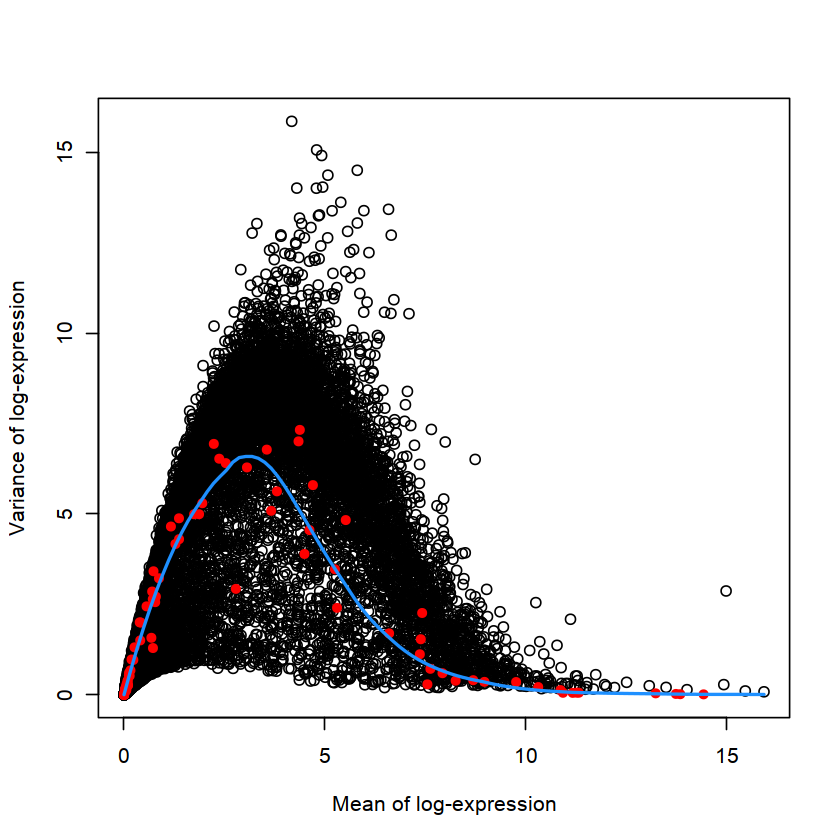

In [33]:
plot(dec.spike.416b$mean, dec.spike.416b$total, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
fit.spike.416b <- metadata(dec.spike.416b)
points(fit.spike.416b$mean, fit.spike.416b$var, col="red", pch=16)
curve(fit.spike.416b$trend(x), col="dodgerblue", add=TRUE, lwd=2)

In the absence of spike-in data, one can attempt to create a trend by making some distributional assumptions about the noise. For example, UMI counts typically exhibit near-Poisson variation if we only consider technical noise from library preparation and sequencing. This can be used to construct a mean-variance trend in the log-counts (Figure 3.3) with the modelGeneVarByPoisson() function. Note the increased residuals of the high-abundance genes, which can be interpreted as the amount of biological variation that was assumed to be “uninteresting” when fitting the gene-based trend in Figure 3.1.

In [34]:
set.seed(0010101)
dec.pois.pbmc <- modelGeneVarByPoisson(sce.pbmc)
dec.pois.pbmc <- dec.pois.pbmc[order(dec.pois.pbmc$bio, decreasing=TRUE),]
head(dec.pois.pbmc)

DataFrame with 6 rows and 6 columns
             mean     total      tech       bio   p.value       FDR
        <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
LYZ       1.95605   5.05854  0.631190   4.42735         0         0
S100A9    1.93416   4.53551  0.635102   3.90040         0         0
S100A8    1.69961   4.41084  0.671491   3.73935         0         0
HLA-DRA   2.09785   3.75174  0.604448   3.14730         0         0
CD74      2.90176   3.36879  0.444928   2.92386         0         0
CST3      1.47546   2.95646  0.691386   2.26507         0         0

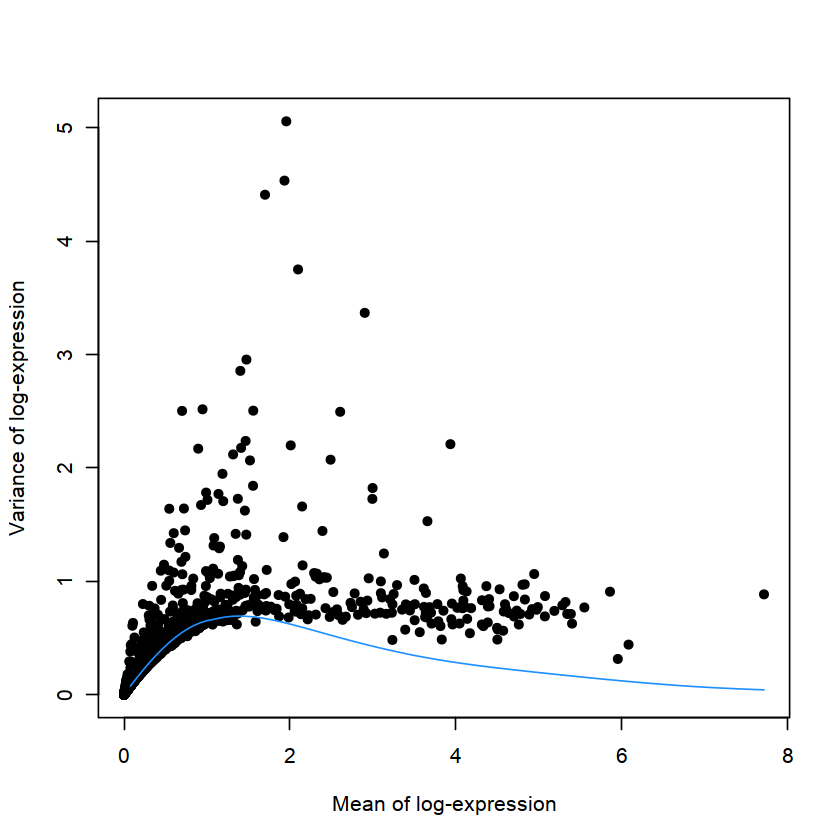

In [35]:
plot(dec.pois.pbmc$mean, dec.pois.pbmc$total, pch=16, xlab="Mean of log-expression",
    ylab="Variance of log-expression")
curve(metadata(dec.pois.pbmc)$trend(x), col="dodgerblue", add=TRUE)

Interestingly, trends based purely on technical noise tend to yield large biological components for highly-expressed genes. This often includes so-called “house-keeping” genes coding for essential cellular components such as ribosomal proteins, which are considered uninteresting for characterizing cellular heterogeneity. These observations suggest that a more accurate noise model does not necessarily yield a better ranking of HVGs, though one should keep an open mind - house-keeping genes are regularly DE in a variety of conditions (Glare et al. 2002; Nazari, Parham, and Maleki 2015; Guimaraes and Zavolan 2016), and the fact that they have large biological components indicates that there is strong variation across cells that may not be completely irrelevant.

#  Handling batch effects

Data containing multiple batches will often exhibit batch effects - see Multi-sample Chapter 1 for more details. We are usually not interested in HVGs that are driven by batch effects; instead, we want to focus on genes that are highly variable within each batch. This is naturally achieved by performing trend fitting and variance decomposition separately for each batch. We demonstrate this approach by treating each plate (block) in the 416B dataset as a different batch, using the `modelGeneVarWithSpikes()` function. (The same argument is available in all other variance-modelling functions.)

将batch作为参数传入函数，关注的是每个batch内部的变异性，而不是batch间的变异性。

In [52]:
levels(factor(sce.416b$block))

[1] "20160113" "20160325"

In [36]:
dec.block.416b <- modelGeneVarWithSpikes(sce.416b, "ERCC", block=sce.416b$block)
head(dec.block.416b[order(dec.block.416b$bio, decreasing=TRUE),1:6])

DataFrame with 6 rows and 6 columns
             mean     total      tech       bio      p.value          FDR
        <numeric> <numeric> <numeric> <numeric>    <numeric>    <numeric>
Lyz2      6.58712   13.4224   1.60775   11.8147  0.00000e+00  0.00000e+00
Top2a     5.80971   14.3246   2.74063   11.5840 7.36122e-145 1.84395e-142
Ccl9      6.65264   12.7821   1.46884   11.3132  0.00000e+00  0.00000e+00
Hbb-bt    4.92121   14.9694   4.10829   10.8611  2.52635e-52  1.45216e-50
Ccnb2     5.97400   13.2558   2.46701   10.7888 3.33418e-157 9.22598e-155
Cd200r3   4.79717   15.0889   4.37580   10.7131  4.02555e-47  2.06457e-45

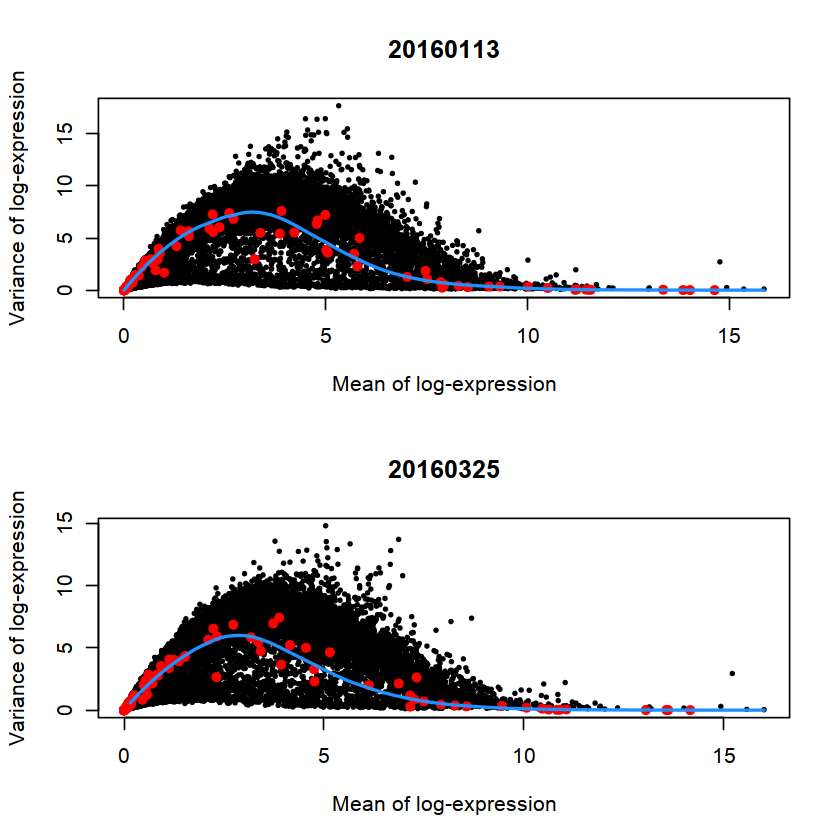

In [38]:
par(mfrow=c(2,1))
blocked.stats <- dec.block.416b$per.block
for (i in colnames(blocked.stats)) {
    current <- blocked.stats[[i]]
    plot(current$mean, current$total, main=i, pch=16, cex=0.5,
        xlab="Mean of log-expression", ylab="Variance of log-expression")
    curfit <- metadata(current)
    points(curfit$mean, curfit$var, col="red", pch=16)
    curve(curfit$trend(x), col='dodgerblue', add=TRUE, lwd=2) 
}

# Selecting highly variable genes

Once we have quantified the per-gene variation, the next step is to select the subset of HVGs to use in downstream analyses. A larger subset will reduce the risk of discarding interesting biological signal by retaining more potentially relevant genes, at the cost of increasing noise from irrelevant genes that might obscure said signal. It is difficult to determine the optimal trade-off for any given application as noise in one context may be useful signal in another. For example, heterogeneity in T cell activation responses is an interesting phenomena (Richard et al. 2018) but may be irrelevant noise in studies that only care about distinguishing the major immunophenotypes.

The most obvious selection strategy is to take the top n genes with the largest values for the relevant variance metric. The main advantage of this approach is that the user can directly control the number of genes retained, which ensures that the computational complexity of downstream calculations is easily predicted. For modelGeneVar() and modelGeneVarWithSpikes(), we would select the genes with the largest biological components. This is conveniently done for us via getTopHVgs(), as shown below with n = 1000.

In [39]:
# Taking the top 1000 genes here:
hvg.pbmc.var <- getTopHVGs(dec.pbmc, n=1000)
str(hvg.pbmc.var)

 chr [1:1000] "LYZ" "S100A9" "S100A8" "HLA-DRA" "CD74" "CST3" "TYROBP" ...


# Putting it all together

The code chunk below will select the top 10% of genes with the highest biological components.

In [40]:
dec.pbmc <- modelGeneVar(sce.pbmc)
chosen <- getTopHVGs(dec.pbmc, prop=0.1)
str(chosen)

 chr [1:1274] "LYZ" "S100A9" "S100A8" "HLA-DRA" "CD74" "CST3" "TYROBP" ...


We then have several options to enforce our HVG selection on the rest of the analysis.

- We can subset the `SingleCellExperiment` to only retain our selection of HVGs. This ensures that downstream methods will only use these genes for their calculations. The downside is that the non-HVGs are discarded from the new `SingleCellExperiment`, making it slightly more inconvenient to interrogate the full dataset for interesting genes that are not HVGs.

In [41]:
sce.pbmc.hvg <- sce.pbmc[chosen,]
dim(sce.pbmc.hvg)

[1] 1274 3985

In [53]:
sce.pbmc.hvg

class: SingleCellExperiment 
dim: 1274 3985 
metadata(1): Samples
assays(2): counts logcounts
rownames(1274): LYZ S100A9 ... TNNT1 TMEM55A
rowData names(2): ID Symbol
colnames(3985): AAACCTGAGAAGGCCT-1 AAACCTGAGACAGACC-1 ...
  TTTGTCAGTTAAGACA-1 TTTGTCATCCCAAGAT-1
colData names(3): Sample Barcode sizeFactor
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(1): original

- We can keep the original `SingleCellExperiment` object and specify the genes to use for downstream functions via an extra argument like subset.row=. This is useful if the analysis uses multiple sets of HVGs at different steps, whereby one set of HVGs can be easily swapped for another in specific steps.

  这种方式最接近于scanpy流程

In [42]:
# Performing PCA only on the chosen HVGs.
library(scater)
sce.pbmc <- runPCA(sce.pbmc, subset_row=chosen)
reducedDimNames(sce.pbmc)

[1] "PCA"

This approach is facilitated by the `rowSubset()` utility, which allows us to easily store one or more sets of interest in our SingleCellExperiment. By doing so, we avoid the need to keep track of a separate chosen variable and ensure that our HVG set is synchronized with any downstream row subsetting of sce.pbmc.

In [43]:
rowSubset(sce.pbmc) <- chosen # stored in the default 'subset'.
rowSubset(sce.pbmc, "HVGs.more") <- getTopHVGs(dec.pbmc, prop=0.2)
rowSubset(sce.pbmc, "HVGs.less") <- getTopHVGs(dec.pbmc, prop=0.3)
colnames(rowData(sce.pbmc))

[1] "ID"        "Symbol"    "subset"    "HVGs.more" "HVGs.less"

- We can have our cake and eat it too by (ab)using the “alternative Experiment” system in the SingleCellExperiment class. Initially designed for storing alternative features like spike-ins or antibody tags, we can instead use it to hold our full dataset while we perform our downstream operations conveniently on the HVG subset. This avoids book-keeping problems in long analyses when the original dataset is not synchronized with the HVG subsetted data.

In [44]:
# Recycling the class above.
altExp(sce.pbmc.hvg, "original") <- sce.pbmc
altExpNames(sce.pbmc.hvg)

[1] "original"

In [62]:
sce.pbmc.hvg

class: SingleCellExperiment 
dim: 1274 3985 
metadata(1): Samples
assays(2): counts logcounts
rownames(1274): LYZ S100A9 ... TNNT1 TMEM55A
rowData names(2): ID Symbol
colnames(3985): AAACCTGAGAAGGCCT-1 AAACCTGAGACAGACC-1 ...
  TTTGTCAGTTAAGACA-1 TTTGTCATCCCAAGAT-1
colData names(3): Sample Barcode sizeFactor
reducedDimNames(1): PCA
mainExpName: NULL
altExpNames(1): original

In [45]:
# No need for explicit subset_row= specification in downstream operations.
sce.pbmc.hvg <- runPCA(sce.pbmc.hvg)

# Recover original data:
sce.pbmc.original <- altExp(sce.pbmc.hvg, "original", withColData=TRUE)